In [1]:
import sys
import time
import csv
import math
import numpy as np
from pyspark import SparkContext
import json
from operator import add
import pandas as pd
import xgboost as xgb
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from node2vec import Node2Vec as n2v
import networkx as nx
from hashlib import md5
import pickle
import os

pd.set_option('display.max_rows', None)

def PartHash(string):
    seed = 131
    hash = 0
    for ch in string:
        hash = hash * seed + ord(ch)
    return hash & 0x7FFFFFFF


# folder_path = "datasets/"
# test_filepath = "datasets/yelp_val.csv"
# output_filepath = "../output_task2_2.csv"
folder_path = "../data/"
test_filepath = "../yelp_true.csv"
output_filepath = ""

from utils import create_category_md5_mapping, integrate_mapping_user_bus_cat_data, dataframe_to_rdd_dict, analyze_top_business_categories, analyze_top_categories

In [2]:
sc = SparkContext('local[*]', 'graphembedding').getOrCreate()
sc.setLogLevel("ERROR")

24/04/17 04:14:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 46042)
Traceback (most recent call last):
  File "/usr/lib/python3.8/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.8/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.8/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.8/socketserver.py", line 747, in __init__
    self.handle()
  File "/usr/local/lib/p

# INITIALIZE

In [3]:
from better_features import FeatureProcessor, read_json_data, transform_user_data, transform_business_data,extract_review_data,extract_business_data

folder_path = '../data/'
user_parsed_df = pd.read_csv('../well-trained/cache/user_df.csv')
business_parsed_df = pd.read_csv('../well-trained/cache/business_df.csv')
review_data = read_json_data(folder_path + '/review_train.json', extract_review_data, sc).collect()

feature_processor = FeatureProcessor(user_parsed_df, business_parsed_df, review_data)

In [4]:
from utils import integrate_mapping_user_bus_cat_data
# category: category md5 mapping
category_md5_df = create_category_md5_mapping(feature_processor.business_df)

# historical reviews 
final_mapped_review_df = integrate_mapping_user_bus_cat_data(feature_processor.df_conn, category_md5_df, review_data)

# Cluster Analysis based on REVIEW (TODO: tip data)

## START HERE

In [65]:
#### CHANGE df to evalute
# file_path = '../yelp_combined.csv'
file_path = '../yelp_true.csv'
df = pd.read_csv(file_path)

In [66]:
##################READY FOR ANALYSIS

In [67]:
user_business_sets = final_mapped_review_df.groupby('user_id')['business_id'].agg(lambda x: set(x)).reset_index()
user_business_sets.columns = ['user_id', 'visited_business_ids']

In [68]:
business_city_map = business_parsed_df.set_index('business_id')['city'].to_dict()

In [69]:
def count_city_visits(business_ids):
    city_counts = {}
    for bid in business_ids:
        city = business_city_map.get(bid, None)
        if city:
            city_counts[city] = city_counts.get(city, 0) + 1
    return city_counts

In [70]:
# Optional (用test dataset 去看小规模分布)
user_business_sets = user_business_sets.loc[user_business_sets['user_id'].isin(df['user_id'])]
# user_business_sets.head()

In [71]:
# 用户城市访问分布数据
user_business_sets['city_visit_distribution'] = user_business_sets['visited_business_ids'].apply(count_city_visits)

In [72]:
# print(user_business_sets[['user_id', 'city_visit_distribution']].head())

# from collections import Counter
# def compute_stats(city_visits):
#     city_counter = Counter(city_visits)
#     most_common_city, most_common_visits = city_counter.most_common(1)[0]
#     total_visits = sum(city_visits.values())
#     mean_visits = total_visits / len(city_visits)
#     var_visits = sum((x - mean_visits) ** 2 for x in city_visits.values()) / len(city_visits)
#     return {
#         "most_common_city": most_common_city,
#         "most_common_visits": most_common_visits,
#         "mean_visits": mean_visits,
#         "variance_visits": var_visits
#     }

# user_business_sets['stats'] = user_business_sets['city_visit_distribution'].apply(compute_stats)
# # print(user_business_sets[['user_id', 'stats']].head())

In [94]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 创建城市矩阵
# 先获取所有城市的列表
all_cities = set()
for dist in user_business_sets['city_visit_distribution']:
    all_cities.update(dist.keys())
all_cities = list(all_cities)

# 构建城市访问矩阵
# 将用户的城市访问频次转换为一个矩阵形式，每个元素表示对应用户对应城市的访问次数。
def create_city_vector(city_distribution):
    return [city_distribution.get(city, 0) for city in all_cities]

city_matrix = pd.DataFrame(user_business_sets['city_visit_distribution'].apply(create_city_vector).tolist(), columns=all_cities)
city_matrix.insert(0, 'user_id', user_business_sets['user_id'])  # 将user_id也加入到矩阵中

# 标准化数据
scaler = StandardScaler()
city_matrix_scaled = scaler.fit_transform(city_matrix.drop('user_id', axis=1))

# 应用K-means聚类
kmeans = KMeans(n_clusters=9)  # best k = 8
clusters = kmeans.fit_predict(city_matrix_scaled)

# 将聚类结果添加到原始DataFrame
city_matrix['Cluster'] = clusters

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [95]:
# 计算每个聚类的城市访问均值
cluster_city_means = city_matrix.groupby('Cluster')[all_cities].mean()

## FIND BEST K Cluster on various dataset : K= 8/9

### combined

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explic

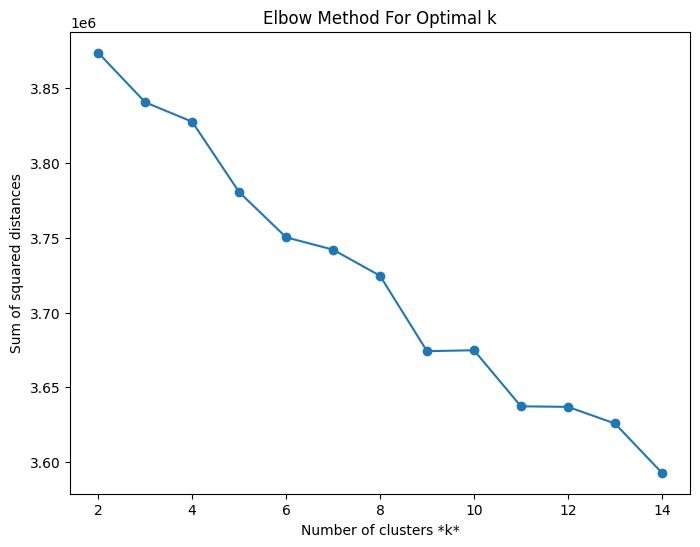

In [43]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = []
list_k = list(range(2, 15))  # 例如检查从2到10的聚类数量
for k in list_k:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(city_matrix_scaled)  # 假设city_matrix_scaled是前面标准化的数据
    sse.append(km.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explic

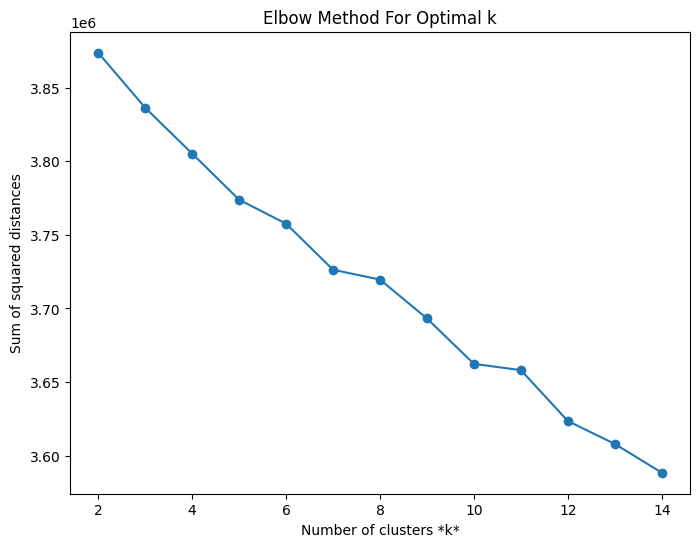

In [63]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = []
list_k = list(range(2, 15))  # 例如检查从2到10的聚类数量
for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(city_matrix_scaled)  # 假设city_matrix_scaled是前面标准化的数据
    sse.append(km.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explic

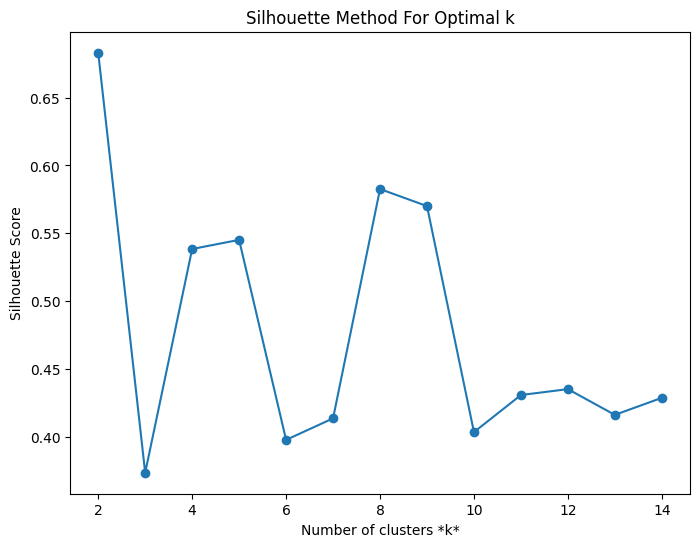

In [44]:
from sklearn.metrics import silhouette_score

sil = []
list_k = list(range(2, 15))  # 轮廓系数至少从2个聚类开始计算

for k in list_k:
    km = KMeans(n_clusters=k, random_state=42)
    cluster_labels = km.fit_predict(city_matrix_scaled)
    silhouette_avg = silhouette_score(city_matrix_scaled, cluster_labels)
    sil.append(silhouette_avg)

plt.figure(figsize=(8, 6))
plt.plot(list_k, sil, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For Optimal k')
plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explic

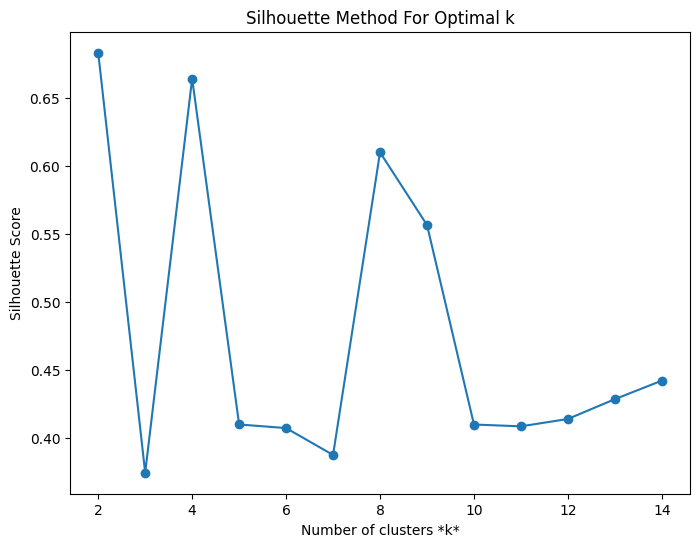

In [64]:
from sklearn.metrics import silhouette_score

sil = []
list_k = list(range(2, 15))  # 轮廓系数至少从2个聚类开始计算

for k in list_k:
    km = KMeans(n_clusters=k)
    cluster_labels = km.fit_predict(city_matrix_scaled)
    silhouette_avg = silhouette_score(city_matrix_scaled, cluster_labels)
    sil.append(silhouette_avg)

plt.figure(figsize=(8, 6))
plt.plot(list_k, sil, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For Optimal k')
plt.show()

### test

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explic

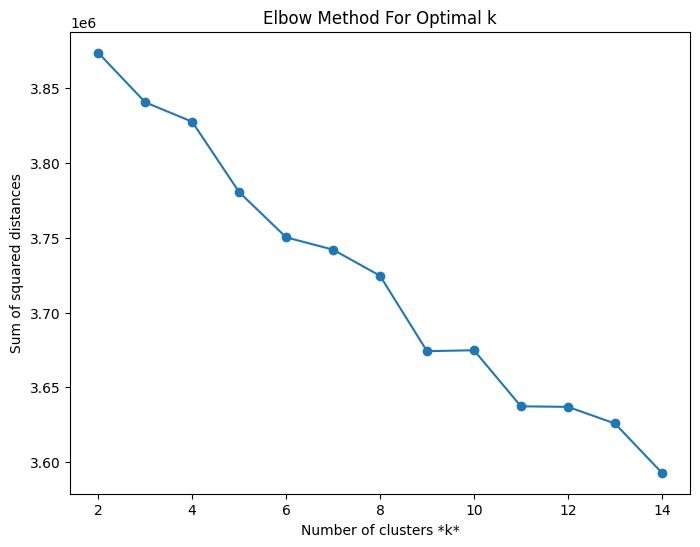

In [27]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = []
list_k = list(range(2, 15))  # 例如检查从2到10的聚类数量
for k in list_k:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(city_matrix_scaled)  # 假设city_matrix_scaled是前面标准化的数据
    sse.append(km.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explic

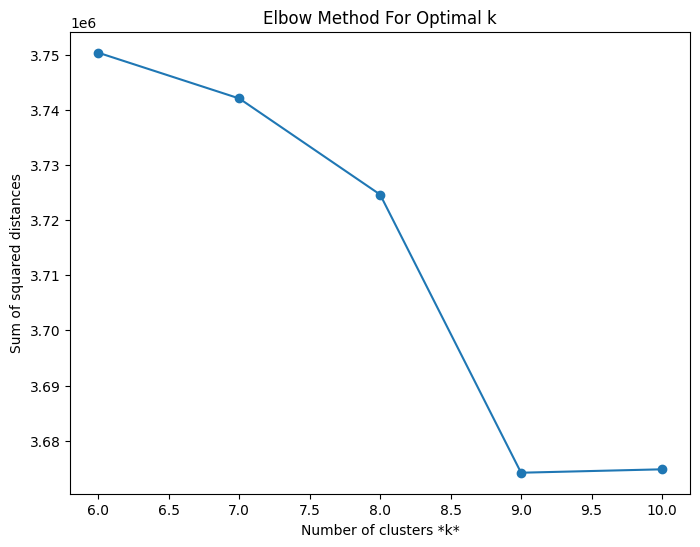

In [93]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = []
list_k = list(range(6, 11))  # 例如检查从2到10的聚类数量
for k in list_k:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(city_matrix_scaled)  # 假设city_matrix_scaled是前面标准化的数据
    sse.append(km.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explic

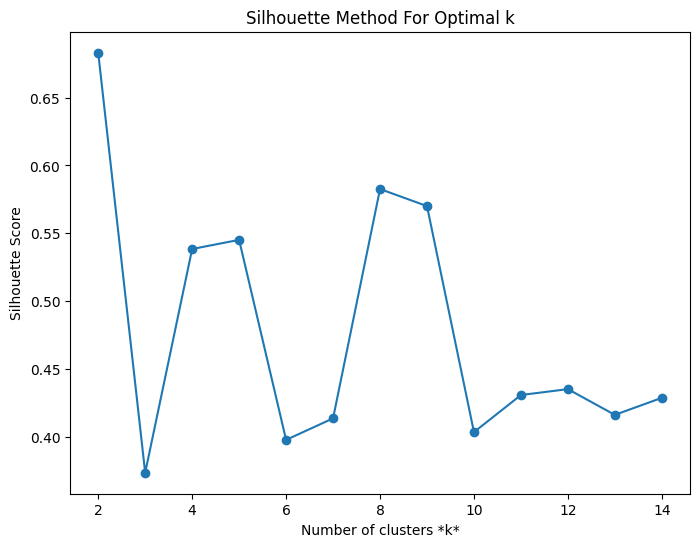

In [28]:
from sklearn.metrics import silhouette_score

sil = []
list_k = list(range(2, 15))  # 轮廓系数至少从2个聚类开始计算

for k in list_k:
    km = KMeans(n_clusters=k, random_state=42)
    cluster_labels = km.fit_predict(city_matrix_scaled)
    silhouette_avg = silhouette_score(city_matrix_scaled, cluster_labels)
    sil.append(silhouette_avg)

plt.figure(figsize=(8, 6))
plt.plot(list_k, sil, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For Optimal k')
plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explic

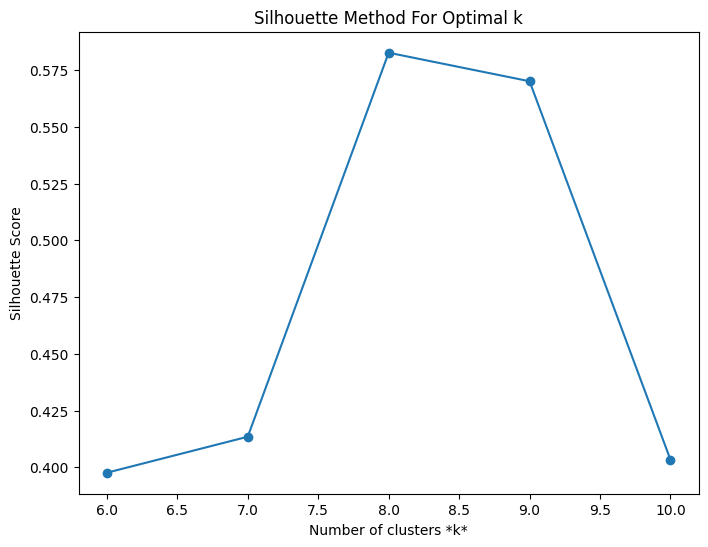

In [92]:
from sklearn.metrics import silhouette_score

sil = []
list_k = list(range(6, 11))  # 轮廓系数至少从2个聚类开始计算

for k in list_k:
    km = KMeans(n_clusters=k, random_state=42)
    cluster_labels = km.fit_predict(city_matrix_scaled)
    silhouette_avg = silhouette_score(city_matrix_scaled, cluster_labels)
    sil.append(silhouette_avg)

plt.figure(figsize=(8, 6))
plt.plot(list_k, sil, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For Optimal k')
plt.show()

## Conclusion and Visualization
k = 8/9是最好的聚类点，在单独的test data和所有data上，都是轮廓系数最高的K值，而且两种情况下的SSE曲线和轮廓系数图的走势都非常相似；说明采样是相对平均的

### ALL data visualization

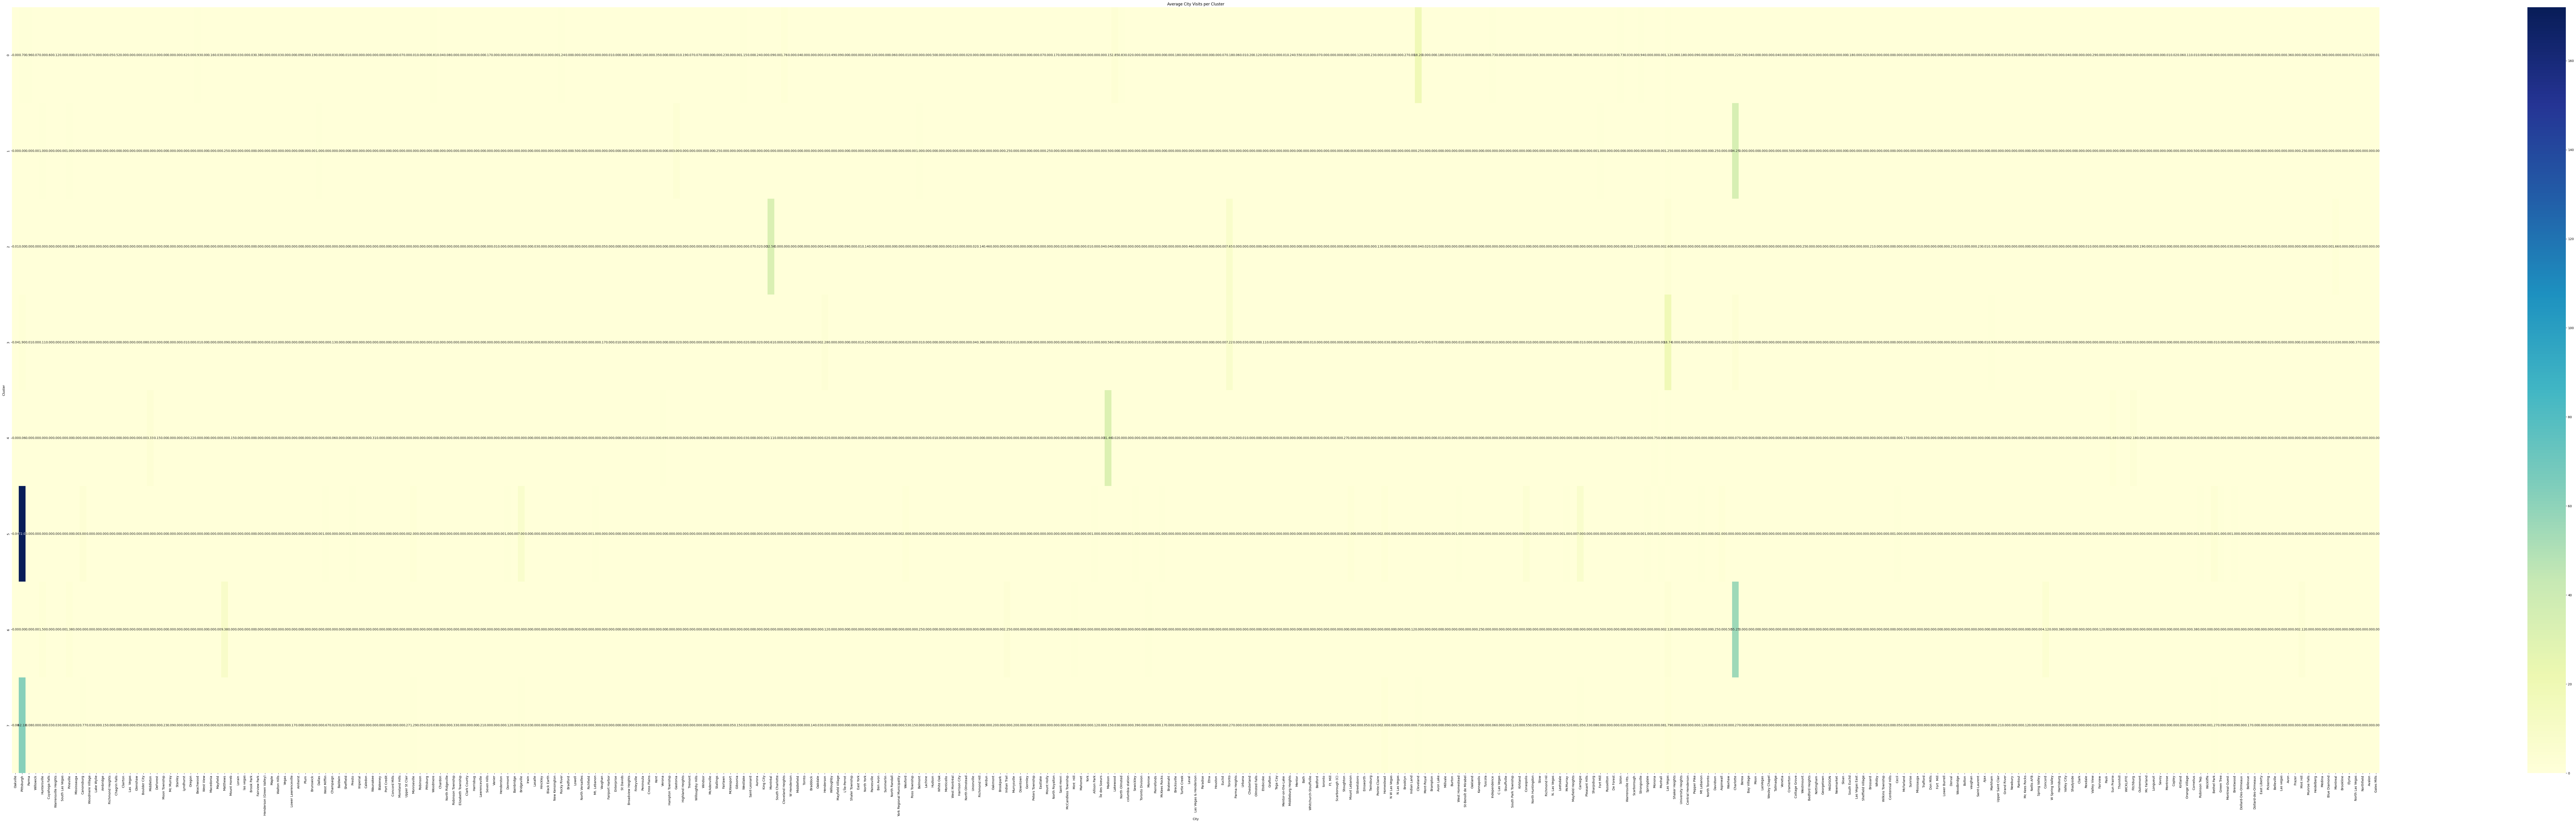

In [103]:
import seaborn as sns
plt.figure(figsize=(169, 44))
sns.heatmap(cluster_city_means, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Average City Visits per Cluster')
plt.xlabel('City')
plt.ylabel('Cluster')
plt.show()

In [104]:
# 对每个聚类进行描述性统计分析
for i in range(kmeans.n_clusters):
    print(f"Cluster {i}:")
    top_cities = cluster_city_means.loc[i].sort_values(ascending=False).head(5)
    print(f"Top cities for this cluster: {top_cities}")
    print()

Cluster 0:
Top cities for this cluster: Cleveland            18.204482
Lakewood              2.845938
Cleveland Heights     1.756303
Rocky River           1.235294
Westlake              1.145658
Name: 0, dtype: float64

Cluster 1:
Top cities for this cluster: Charlotte    34.25
Gastonia      3.00
Las Vegas     1.25
Dallas        1.00
Fort Mill     1.00
Name: 1, dtype: float64

Cluster 2:
Top cities for this cluster: Montréal     32.558824
Toronto       7.647059
Las Vegas     2.600000
Montreal      1.664706
Verdun        0.464706
Name: 2, dtype: float64

Cluster 3:
Top cities for this cluster: Las Vegas     18.744197
Toronto        7.223875
Charlotte      3.033728
Henderson      2.277594
Pittsburgh     1.898058
Name: 3, dtype: float64

Cluster 4:
Top cities for this cluster: Madison        31.458716
Middleton       3.330275
Fitchburg       2.183486
Sun Prairie     1.678899
Las Vegas       0.880734
Name: 4, dtype: float64

Cluster 5:
Top cities for this cluster: Pittsburgh     172.0
Carn

### Test Data Visualization

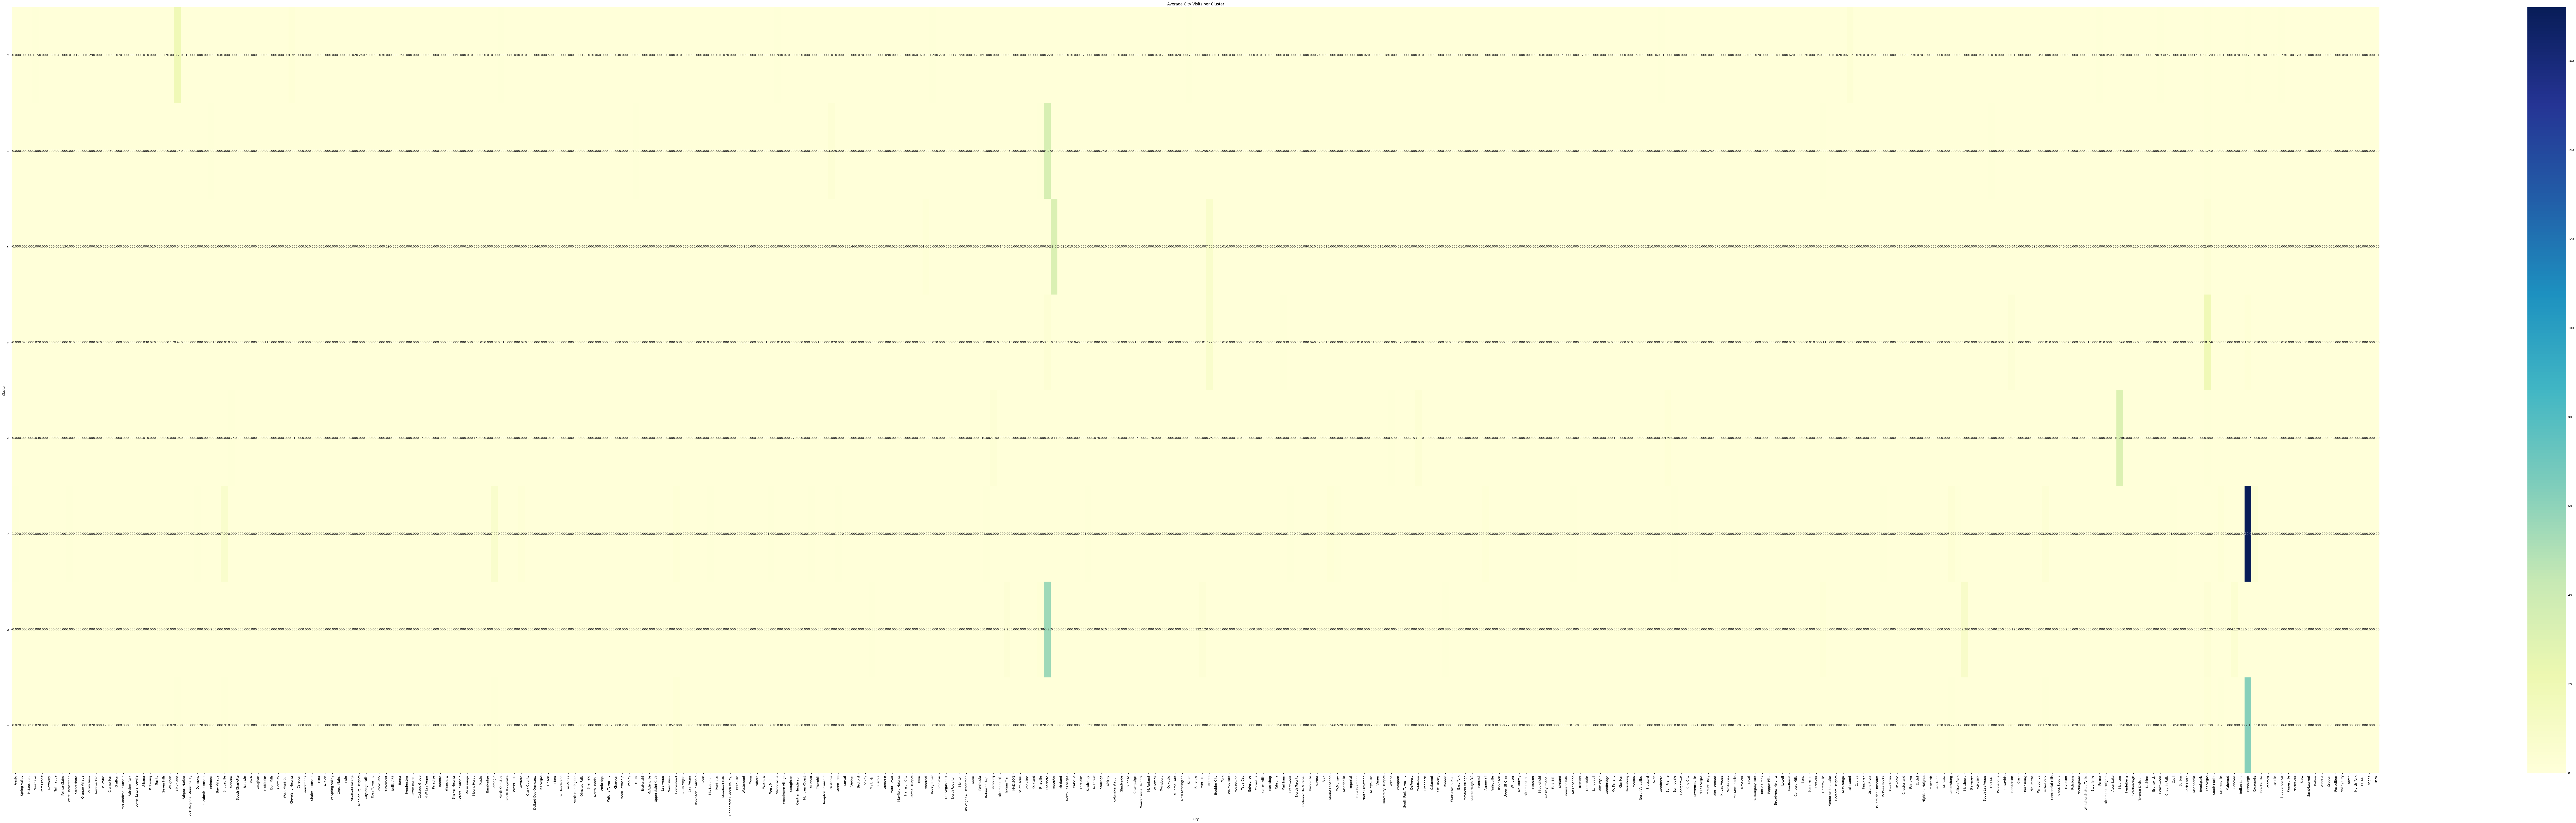

In [29]:
import seaborn as sns
plt.figure(figsize=(169, 44))
sns.heatmap(cluster_city_means, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Average City Visits per Cluster')
plt.xlabel('City')
plt.ylabel('Cluster')
plt.show()

In [30]:
# 对每个聚类进行描述性统计分析
for i in range(kmeans.n_clusters):
    print(f"Cluster {i}:")
    top_cities = cluster_city_means.loc[i].sort_values(ascending=False).head(5)
    print(f"Top cities for this cluster: {top_cities}")
    print()

Cluster 0:
Top cities for this cluster: Cleveland            18.204482
Lakewood              2.845938
Cleveland Heights     1.756303
Rocky River           1.235294
Westlake              1.145658
Name: 0, dtype: float64

Cluster 1:
Top cities for this cluster: Charlotte    34.25
Gastonia      3.00
Las Vegas     1.25
Pineville     1.00
Dallas        1.00
Name: 1, dtype: float64

Cluster 2:
Top cities for this cluster: Montréal     32.558824
Toronto       7.647059
Las Vegas     2.600000
Montreal      1.664706
Verdun        0.464706
Name: 2, dtype: float64

Cluster 3:
Top cities for this cluster: Las Vegas     18.744197
Toronto        7.223875
Charlotte      3.033728
Henderson      2.277594
Pittsburgh     1.898058
Name: 3, dtype: float64

Cluster 4:
Top cities for this cluster: Madison        31.458716
Middleton       3.330275
Fitchburg       2.183486
Sun Prairie     1.678899
Las Vegas       0.880734
Name: 4, dtype: float64

Cluster 5:
Top cities for this cluster: Pittsburgh     172.0
Brid

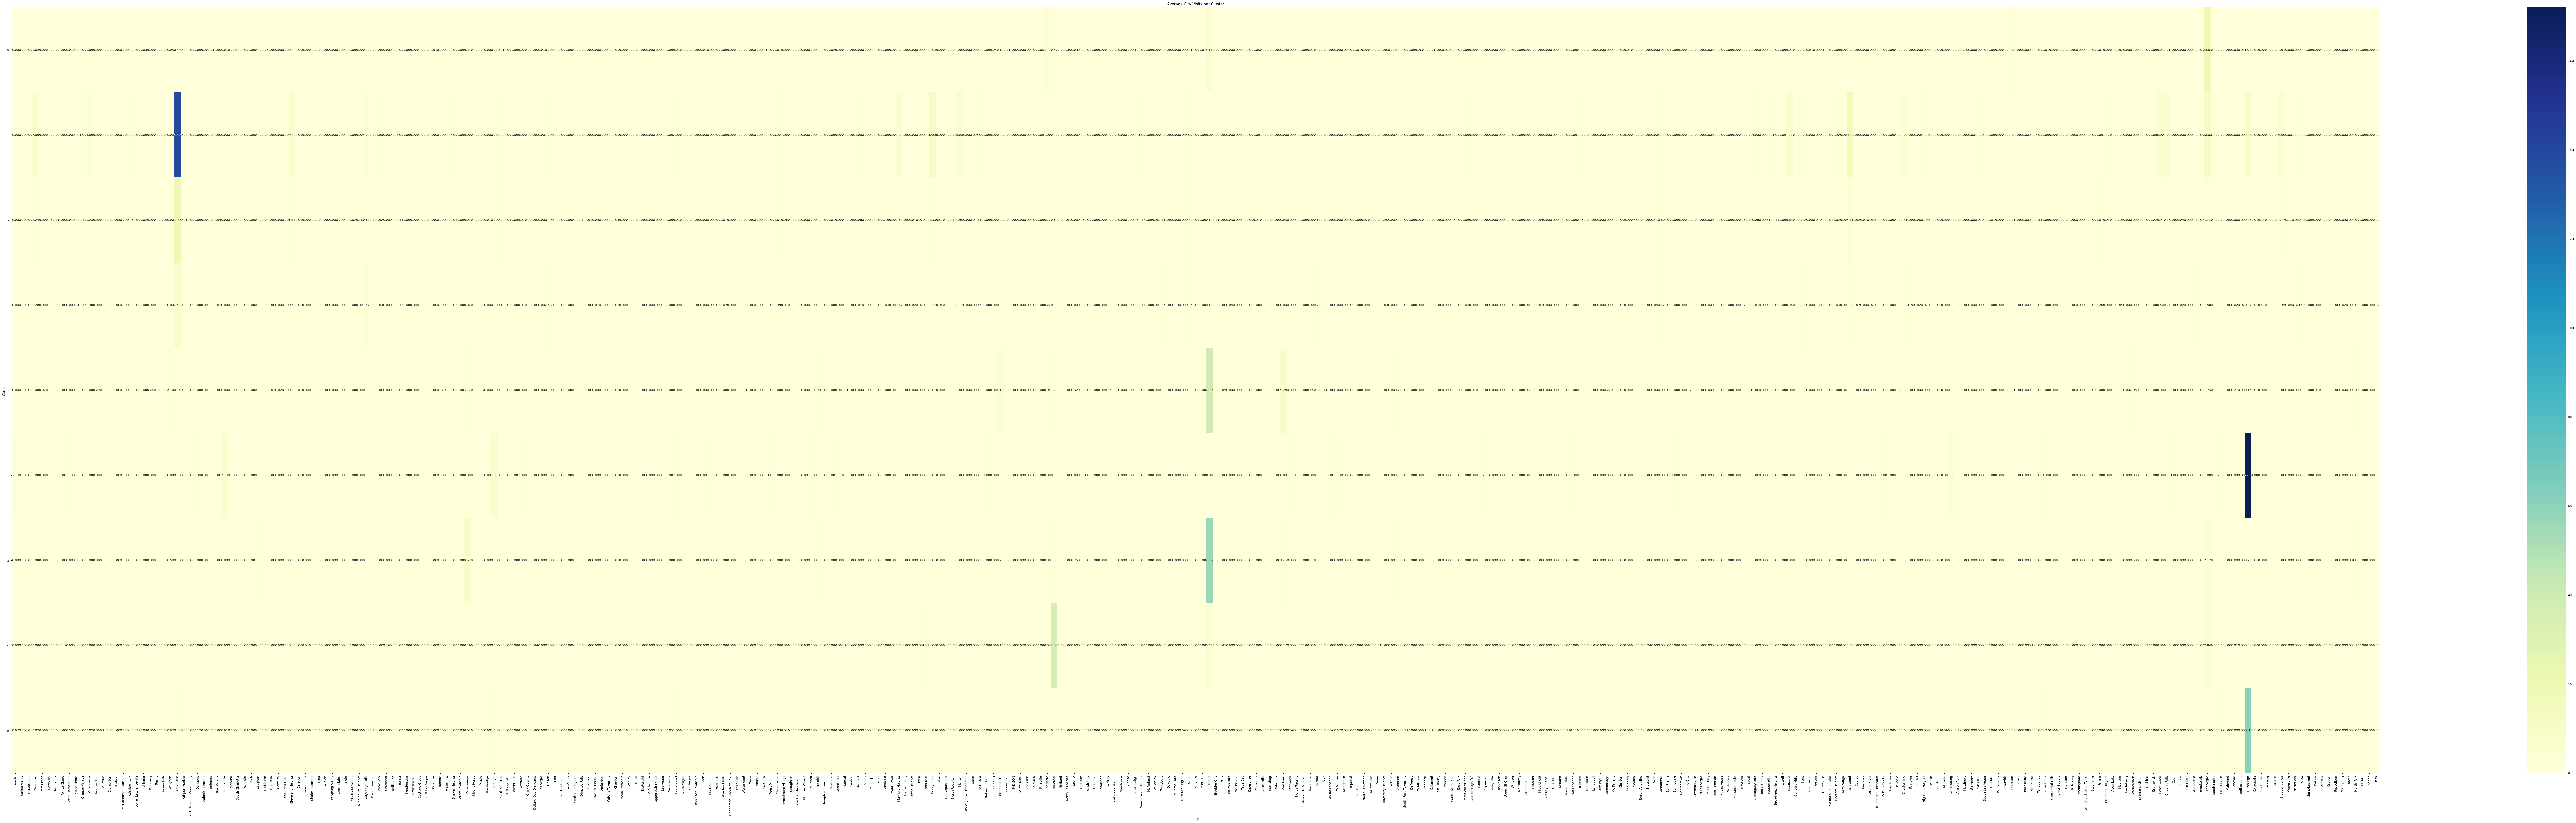

In [96]:
import seaborn as sns
plt.figure(figsize=(169, 44))
sns.heatmap(cluster_city_means, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Average City Visits per Cluster')
plt.xlabel('City')
plt.ylabel('Cluster')
plt.show()

In [97]:
# 对每个聚类进行描述性统计分析
for i in range(kmeans.n_clusters):
    print(f"Cluster {i}:")
    top_cities = cluster_city_means.loc[i].sort_values(ascending=False).head(5)
    print(f"Top cities for this cluster: {top_cities}")
    print()

Cluster 0:
Top cities for this cluster: Las Vegas     19.605856
Toronto        5.158908
Charlotte      3.234144
Henderson      2.386005
Pittsburgh     1.979454
Name: 0, dtype: float64

Cluster 1:
Top cities for this cluster: Cleveland      139.0
Lakewood        17.0
Rocky River     12.0
Las Vegas       10.0
Pittsburgh      10.0
Name: 1, dtype: float64

Cluster 2:
Top cities for this cluster: Cleveland            19.530547
Lakewood              3.109325
Cleveland Heights     1.906752
Rocky River           1.331190
Westlake              1.244373
Name: 2, dtype: float64

Cluster 3:
Top cities for this cluster: Cleveland         7.543478
Cuyahoga Falls    3.565217
Hudson            2.434783
Kent              2.086957
Stow              1.934783
Name: 3, dtype: float64

Cluster 4:
Top cities for this cluster: Toronto          38.352848
Markham           9.284810
Richmond Hill     4.181962
Mississauga       3.868671
North York        2.430380
Name: 4, dtype: float64

Cluster 5:
Top cities for

In [111]:
# an example of cluster3: Cleveland
print(type(cluster_city_means.loc[3]))
cluster_city_means.loc[4].sort_values(ascending=False)[:10]

<class 'pandas.core.series.Series'>


Toronto          38.352848
Markham           9.284810
Richmond Hill     4.181962
Mississauga       3.868671
North York        2.430380
Vaughan           2.099684
Scarborough       2.055380
Thornhill         1.607595
Montréal          1.231013
Etobicoke         0.925633
Name: 4, dtype: float64

In [121]:
cluster_city_means.loc[1].sort_values(ascending=False)[:50]

Cleveland               139.0
Lakewood                 17.0
Rocky River              12.0
Las Vegas                10.0
Pittsburgh               10.0
Cleveland Heights         9.0
Lyndhurst                 7.0
Westlake                  7.0
Mayfield Heights          6.0
Beachwood                 6.0
Independence              6.0
Chagrin Falls             5.0
Mentor                    5.0
Willoughby Hills          4.0
Chesterland               4.0
Valley View               4.0
Strongsville              3.0
Woodmere                  3.0
Highland Heights          3.0
Peninsula                 3.0
Cuyahoga Falls            3.0
Solon                     3.0
Hudson                    2.0
Berea                     2.0
Willoughby                2.0
Homestead                 2.0
Kent                      2.0
Shaker Heights            2.0
Kirtland                  2.0
Stow                      2.0
Tremont                   1.0
Bedford                   1.0
North Olmsted             1.0
Brook Park

### Combined Data (train+val)

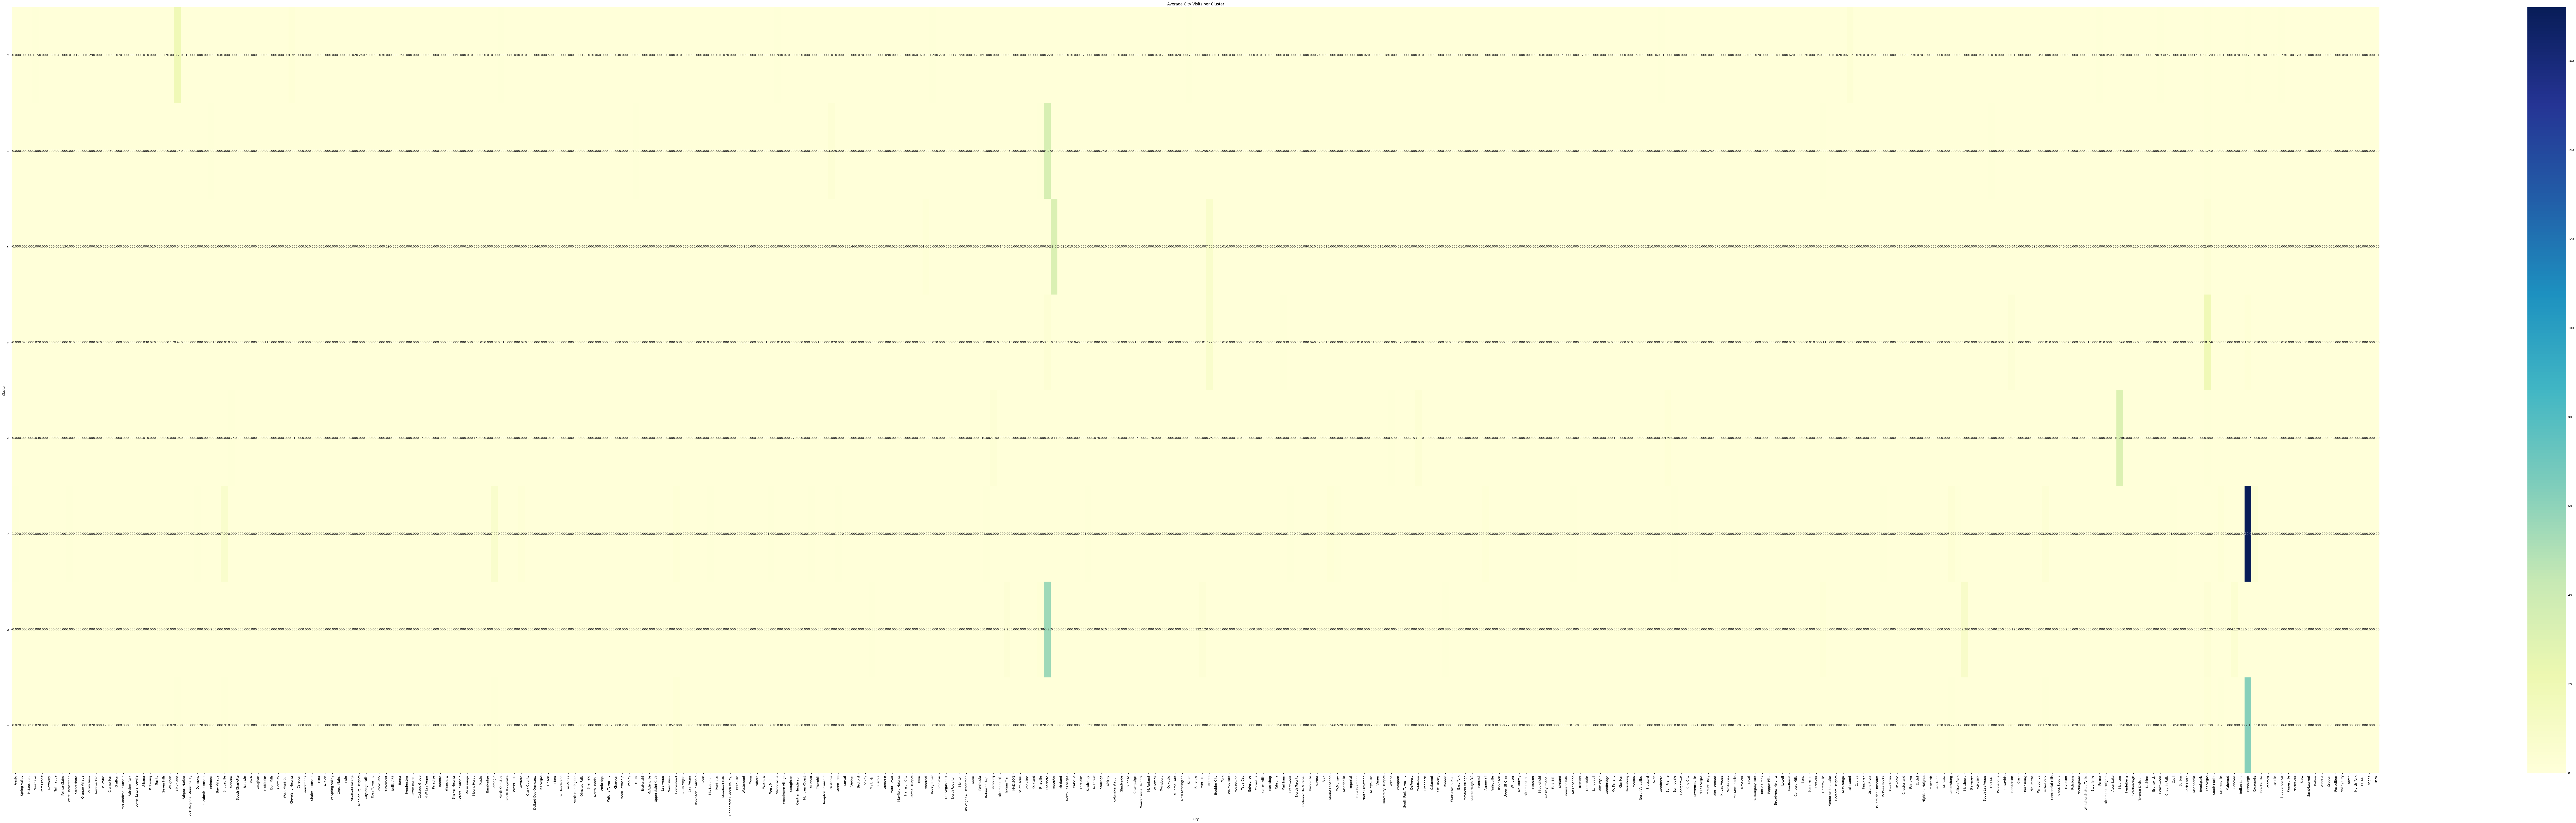

In [45]:
import seaborn as sns
plt.figure(figsize=(169, 44))
sns.heatmap(cluster_city_means, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Average City Visits per Cluster')
plt.xlabel('City')
plt.ylabel('Cluster')
plt.show()

In [46]:
# 对每个聚类进行描述性统计分析
for i in range(kmeans.n_clusters):
    print(f"Cluster {i}:")
    top_cities = cluster_city_means.loc[i].sort_values(ascending=False).head(5)
    print(f"Top cities for this cluster: {top_cities}")
    print()

Cluster 0:
Top cities for this cluster: Cleveland            18.204482
Lakewood              2.845938
Cleveland Heights     1.756303
Rocky River           1.235294
Westlake              1.145658
Name: 0, dtype: float64

Cluster 1:
Top cities for this cluster: Charlotte    34.25
Gastonia      3.00
Las Vegas     1.25
Pineville     1.00
Dallas        1.00
Name: 1, dtype: float64

Cluster 2:
Top cities for this cluster: Montréal     32.558824
Toronto       7.647059
Las Vegas     2.600000
Montreal      1.664706
Verdun        0.464706
Name: 2, dtype: float64

Cluster 3:
Top cities for this cluster: Las Vegas     18.744197
Toronto        7.223875
Charlotte      3.033728
Henderson      2.277594
Pittsburgh     1.898058
Name: 3, dtype: float64

Cluster 4:
Top cities for this cluster: Madison        31.458716
Middleton       3.330275
Fitchburg       2.183486
Sun Prairie     1.678899
Las Vegas       0.880734
Name: 4, dtype: float64

Cluster 5:
Top cities for this cluster: Pittsburgh     172.0
Brid

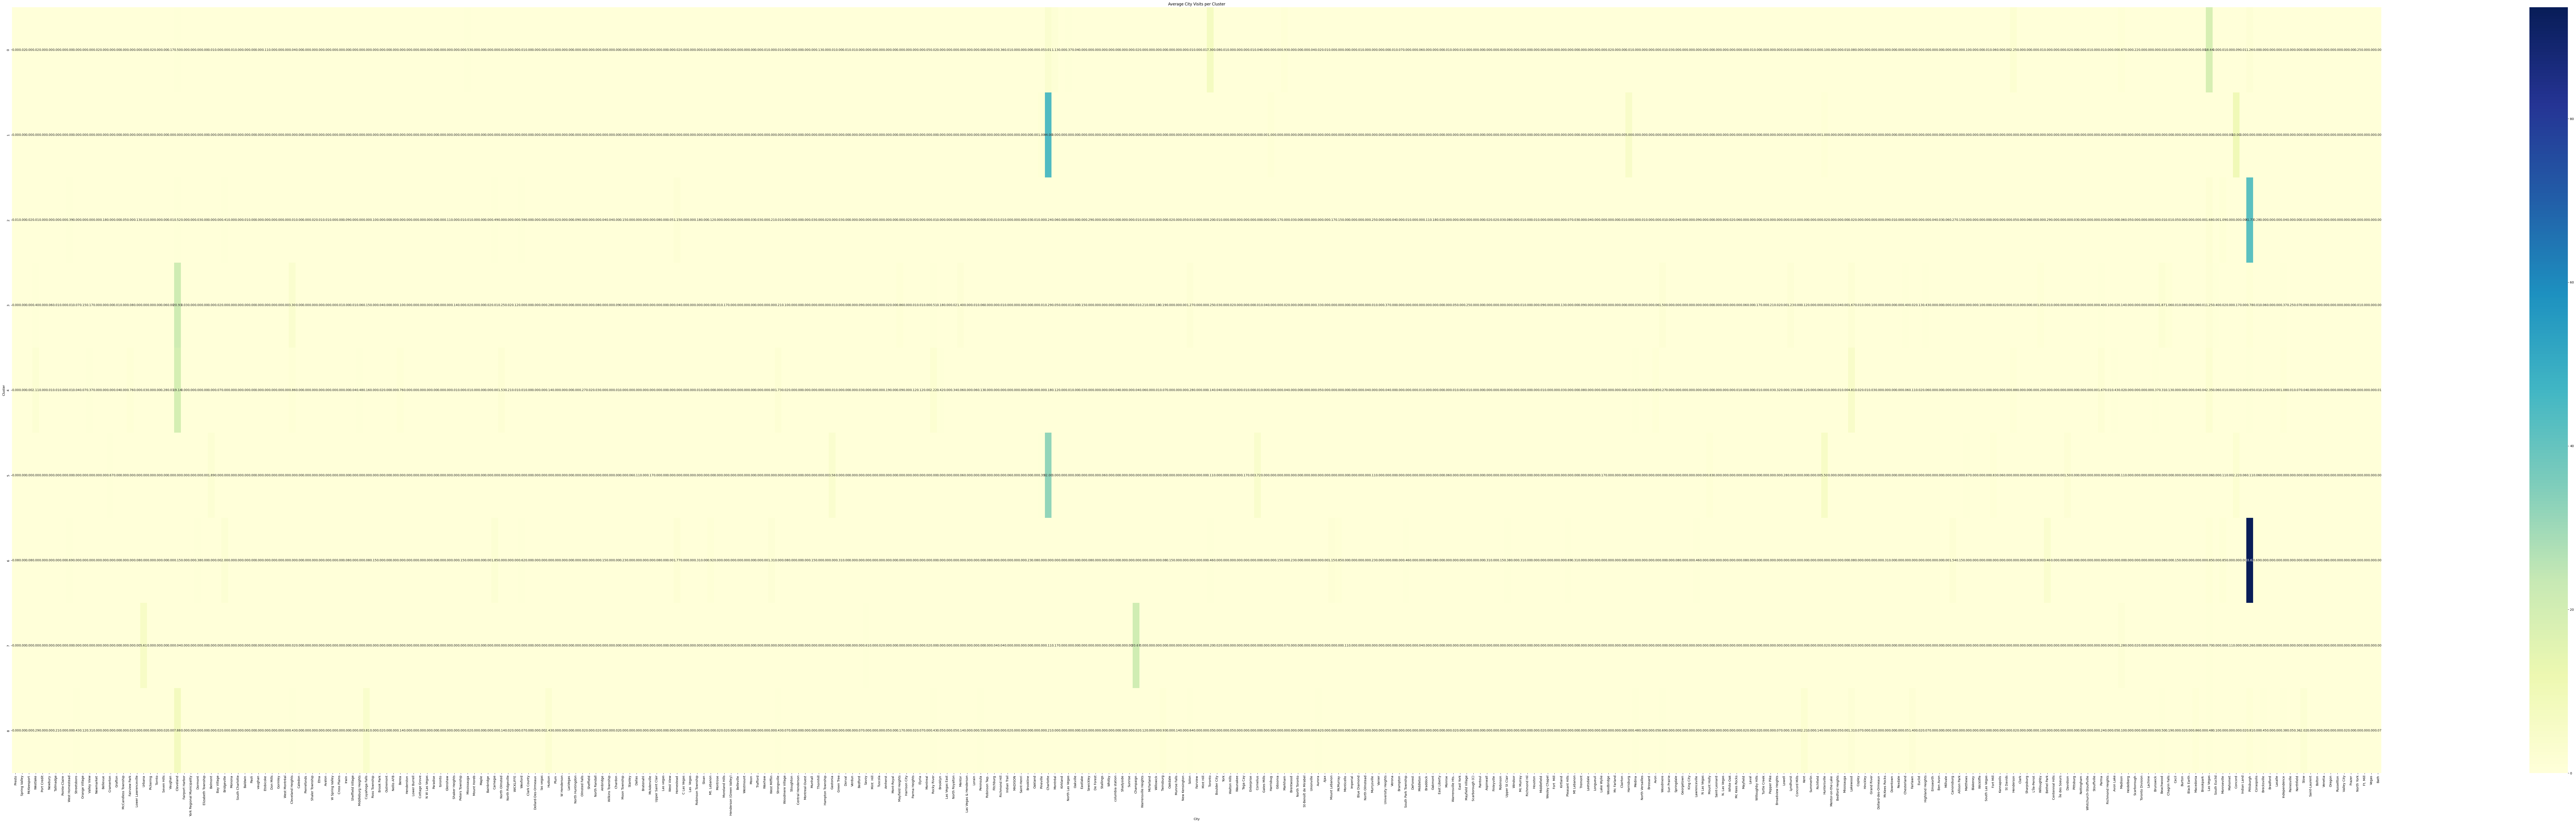

In [50]:
import seaborn as sns
plt.figure(figsize=(169, 44))
sns.heatmap(cluster_city_means, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Average City Visits per Cluster')
plt.xlabel('City')
plt.ylabel('Cluster')
plt.show()

In [49]:
# 对每个聚类进行描述性统计分析
for i in range(kmeans.n_clusters):
    print(f"Cluster {i}:")
    top_cities = cluster_city_means.loc[i].sort_values(ascending=False).head(5)
    print(f"Top cities for this cluster: {top_cities}")
    print()

Cluster 0:
Top cities for this cluster: Las Vegas     18.635063
Toronto        7.300443
Charlotte      3.008662
Henderson      2.250071
Pittsburgh     1.255155
Name: 0, dtype: float64

Cluster 1:
Top cities for this cluster: Charlotte       44.0
Concord         10.0
Harrisburg       5.0
Huntersville     1.0
Harrisbug        1.0
Name: 1, dtype: float64

Cluster 2:
Top cities for this cluster: Pittsburgh     41.730769
Las Vegas       1.683761
Homestead       1.149573
Monroeville     1.094017
Wexford         0.589744
Name: 2, dtype: float64

Cluster 3:
Top cities for this cluster: Cleveland            20.928571
Cleveland Heights     3.301587
Beachwood             1.865079
Lakewood              1.666667
Woodmere              1.500000
Name: 3, dtype: float64

Cluster 4:
Top cities for this cluster: Cleveland      19.136646
Lakewood        4.813665
Las Vegas       2.354037
Rocky River     2.223602
Westlake        2.105590
Name: 4, dtype: float64

Cluster 5:
Top cities for this cluster: Charl

# 分析结果
- k = 8

Cluster 0 的用户集中在Cleveland及其郊区。这表明这些用户可能在地理上相对固定，活动范围相对集中。

Cluster 1 的用户主要在Charlotte地区活跃，但也有在Las Vegas和Dallas的活动。这可能指向一个商务或旅游活动相结合的行为模式。

Cluster 2 的用户集中在加拿大Montréal和Toronto，这可能表示这个群体在加拿大有较强的地缘活动特征。

Cluster 3 的用户在Las Vegas和Toronto两个大城市都有较高的活动频次，暗示可能的商务或娱乐活动偏好。

Cluster 4 集中在Madison及其周边地区，这表明可能是该地区的居民或者对该地区有特殊偏好的游客。

Cluster 5 强烈集中在Pittsburgh，访问次数远高于其他城市，这表明这是一个高度地域化的用户群体。

Cluster 6 的用户主要集中在Charlotte及其周边地区，包括Matthews和Concord，表明这可能是居住在这些区域的用户。

Cluster 7 与Cluster 5类似，也是一个在Pittsburgh有高度集中活动的群体，但访问次数相对较少，这可能是一个小规模或更特定的用户群体。

- **k = 9 in all data**

Cluster 0:
此群体以Las Vegas和Toronto为主要活动地。可能表示用户在这两个大城市有休闲或商务上的重叠兴趣。

Cluster 1:
用户高度集中在Charlotte地区及其郊区，显示了对本地业务的高度集中和忠诚度。

Cluster 2:
以Pittsburgh为中心，这个群体似乎非常专注于这一地区，可能是当地居民或者频繁访客。

Cluster 3:
高度集中在Cleveland，这表明了这个群体可能是基于地理位置的社区，与Cluster 4非常相似，但是与Cluster 4比较，Cluster 3更专注于Cleveland Heights和Beachwood。

Cluster 4:
这个群体类似于Cluster 3，但在Lakewood的活动更加频繁，可能表示对不同城市郊区有不同的偏好。

Cluster 5:
用户的活动范围围绕Charlotte及其周边区域，与Cluster 1有些相似，但对Huntersville和Cornelius有更多的活动。

Cluster 6:
这个群体在Pittsburgh有很高的活动频率，并且在Bethel Park和Bridgeville等周边区域也有一定活动，表明可能对更广泛的地区有兴趣。

Cluster 7:
专注于Champaign和Urbana，与其他聚类明显不同，可能代表了一个特定的地区社区或用户群体。

Cluster 8:
用户在Cleveland有一定的活动，但更多地分布在Cuyahoga Falls、Hudson等城市，这可能反映出不同的地域或生活方式偏好。

- **k = 9 in test data**
  
Cluster 0: 主要活动城市是Las Vegas和Toronto，Las Vegas是绝对主导者，表明用户在这两个城市有重叠的休闲或商务兴趣。

Cluster 1: 主要活动城市是Cleveland和周边地区，其中Cleveland是绝对主导者，显示了该地区的活动频繁程度较高。

Cluster 2: 主要活动城市是Cleveland及其周边地区，其中Cleveland占主导地位，显示了该地区的活动较为频繁。

Cluster 3: 主要活动城市是Cleveland及其周边地区，显示了该地区的活动频繁程度较高。

Cluster 4: 主要活动城市是Toronto及其周边地区，显示了该地区的活动频繁程度较高。

Cluster 5: 主要活动城市是Pittsburgh及其周边地区，显示了该地区的活动频繁程度较高。

Cluster 6: 主要活动城市是Toronto及其周边地区，显示了该地区的活动频繁程度较高。

Cluster 7: 主要活动城市是Montréal及其周边地区，其中Montréal是绝对主导者，显示了该地区的活动频繁程度较高。

Cluster 8: 主要活动城市是Pittsburgh及其周边地区，其中Pittsburgh是绝对主导者，显示了该地区的活动频繁程度较高。

In [122]:
user_clusters = city_matrix[['user_id', 'Cluster']].copy()

In [121]:
print(user_clusters.head())

user_id  Cluster
0      ---1lKK3aKOuomHnwAkAow        3
1      --2vR0DIsmQ6WfcSzKWigw        3
2      --BumyUHiO_7YsHurb9Hkw        3
3      --Qh8yKWAvIP4V4K8ZPfHA        3
4      --RlSfc-QmcHFGHyX6aVjA        3
5      --YhjyV-ce1nFLYxP49C5A        3
6      --ZNfWKj1VyVElRx6-g1fg        3
7      -0-hVEpwWEcJLJoGq3rE3g        3
8      -0HhZbPBlB1YZx3BhAfaEA        3
9      -0b84SUGVN0YkG5j2MCmBw        3
10     -0e6xyw_4zyg-2YtqSlS_g        3
11     -1wbglcr6x1qrUbqP1YAIA        3
12     -24Yo5J2MvjL685lPpQWjw        3
13     -267Yx8RmdP6io2-qI4UcQ        3
14     -2OB54nQ6FsGLUM-R1KXnA        3
15     -2UOdDlzg7XLuUuyOrldhA        3
16     -2gOxVWcnBr5DclrrsWXCA        3
17     -2kCxY7_aw5hOz7fJnGMbQ        3
18     -3Kq9ssSot4QizbPYO6ZQQ        3
19     -3PTUP443q6hQESLKSu95w        3
20     -3s52C4zL_DHRK0ULG6qtg        3
21     -4JDJeFS0YAYSiSvIshGLQ        3
22     -4LBQwoirPM6VPLj4Ko-Bg        3
23     -50XWnmQGqBgEI-9ANvLlg        3
24     -57uOzAWlx__p6QlX1pojA        3
25     -594af_E7Z9VVjQc9pJK3g        3
26     -5Q56Z3K0ZpaDStmOPCt5g        3
27     -5e4VTnu_pR4Gpv3VSncaw        3
28     -5ohKzWWOzAG1M1OtcoPgQ        3
29     -5ye1ya0wRQhNRF9NfQ1fA        3
30     -6559fkJ6rCWIZDbqVUomA        3
31     -7IMRsmV-Gt7KAK3yivZGQ        3
32     -7bM_DeL2Kj2CuYuVDsLNg        3
33     -8BrIcsVPbGhv6EAEqbBfA        3
34     -8EnCioUmDygAbsYZmTeRQ        3
35     -8FDlhUsu5_lVONV_aOnGA        3
36     -8MEYFYRHzGEgqBsDV6m2A        3
37     -8bfKCvDClxD3iKX9o7J5w        3
38     -8nmj3B-tfY_vFiimtBOsw        2
39     -8syaSLDbMXW2F2FApVgig        3
40     -95gDpECFDSjWEL1AIrkAA        3
41     -9JqNce6qGY2fTepA8XpUg        3
42     -9MOrFh1va1SC9BBNlMTeQ        3
43     -9RU4LuI_TfYgv9rBijJoQ        3
44     -9SoHrhiiUVmx6-MkyR4RA        3
45     -9b4s874f_CnznTu4JorRg        2
46     -9da1xk7zgnnfO1uTVYGkA        3
47     -AGXyI_K8StzQ7CGehQ2tQ        3
48     -ARdx8hOcEWlMDjzwLYZ_g        3
49     -AXCpsIGp5Wq1e6wVX4YlA        3
50     -Ak9LVDH8GYyWtIMnNo5Ug        3
51     -Anyb0vB5LrW273whytNRw        3
52     -Aw9kRoXmFptUMN2XkJY9w        3
53     -B4Cf2XLkPr9qMlLPHJAlw        3
54     -B6V0kjokTlOe3GFojv84w        3
55     -BevLRnJhh9JeIT2g5I3mQ        3
56     -C-l8EHSLXtZZVfUAUhsPA        3
57     -C0suJCZXOM93IuqIBaOew        3
58     -CxzWyvRj3b3tvFdelf38w        3
59     -DPkNlW9tR4qfZpoQW4Vjg        3
60     -EJorVxe7h2GSxdiRyMmDA        3
61     -EWQZjRHAKMddHW_dZTvdw        3
62     -FFqZupwGHf-vrsUHMr_vw        3
63     -Fy91nyOFqPv9M_MaZ4W2g        3
64     -HAHTQeOzHX5TCDb7qs9Yw        3
65     -HLE-x7Lpkfprd6er-JFGg        0
66     -HcirMcpUDd3GvexCOCCzg        3
67     -HdbkVr80PlnsNSLbgW-7g        3
68     -HlCe-Ya-4CE2huuEk2_1g        3
69     -ILUcUiVCepCKKC-Wpel5g        3
70     -ILapEusonY1QHyJPvUk2A        3
71     -Ia1lWvBNdgGySyB2VSgNQ        3
72     -IcuwptriARnTWf_EaqgrA        3
73     -K3I3SCFvPS_Aw8B4gBtVQ        3
74     -KVxkJDSTjtPGsamMDG92Q        3
75     -KeEr7ZLjbOskY6GGE54hQ        3
76     -KpEgEen1tj-jdjIS7uVOw        3
77     -LhU9PZZKaP_xFa_rjo9jQ        3
78     -NbeVN5tnwdyYAvdNkKMjw        3
79     -Ng6kNjzZee-hT-RZYg_Eg        3
80     -NwDw6HgVpA4ys6WYcI6Xg        3
81     -NycZLw5rPxqwrkKKI-83w        0
82     -OY3fkHVYy0Dx160rKCiWQ        3
83     -Ox7QPz0G56GOzT0ex-f5Q        3
84     -P3SyBLmBhyhDcYatlBgBQ        3
85     -PAOMIe7lqq1x5GB1pcKMg        3
86     -PHC1ulwHkY4LEmMqmFwPg        3
87     -PTn0MWCbVFsRhTvxDC12g        3
88     -PTtMZYVawqKC6-vIds9lQ        4
89     -PUQqO7rbjmdQ0KwYcbGAg        3
90     -PXJEs_9T0lRKpssxf3otg        3
91     -Q2wBtscwW6JOqlBndji4A        3
92     -Q4HGzcXSCeiqvmY2mg-aQ        3
93     -QViqz6QGfMLUYLY73lysg        3
94     -QmN79YXhQ3X6tckgwrYAg        3
95     -QmmHtp57b3zT79APvRONA        3
96     -R3Liu8xDWu-VpWSW8YlKA        3
97     -RA9NLalwmRTOX_8UMHnVQ        3
98     -RApyq06DMBii7ovXtQnfw        3
99     -RCD8F7qbsLfzT3k1HtMxg        3
100    -RSW2tZMqa-SLrP-Uu0SLg        0
101    -R_hd3xKlnUIi_m-IZsY9Q        3
102  

In [126]:
clusters_cities = pd.DataFrame(columns=['Cluster', 'Cities'])

for cluster_num in cluster_city_means.index:
    # Get the cities in the cluster with non-zero visit counts
    cities_in_cluster = cluster_city_means.loc[cluster_num][cluster_city_means.loc[cluster_num] > 0]
    # Convert the list of cities to a set to remove duplicates
    clusters_cities = pd.concat([clusters_cities, pd.DataFrame({'Cluster': [cluster_num], 'Cities': [cities_in_cluster.index.tolist()]})], ignore_index=True)

In [127]:
clusters_cities

Cluster                                             Cities
0       0  [Pittsburgh, Parma, Willowick, Huntersville, C...
1       1  [Huntersville, Pineville, Matthews, Dallas, Lo...
2       2  [Oakville, Mississauga, Vanier, Lasalle, Vaugh...
3       3  [Oakville, Pittsburgh, Parma, Willowick, Hunte...
4       4  [Pittsburgh, Middleton, DeForest, Oregon, Moun...
5       5  [Pittsburgh, Canonsburg, West Mifflin, Presto,...
6       6  [Huntersville, Pineville, Matthews, Stallings,...
7       7  [Pittsburgh, Parma, Cuyahoga Falls, Warrensvil...

# Start Here: SCRIPTED VERSION in KMeans_user_cluster.py

In [6]:
from KMeans_user_cluster import KMeans_process_user_clusters

In [14]:
# test
from better_features import FeatureProcessor, read_json_data, transform_user_data, transform_business_data,extract_review_data,extract_business_data
from KMeans_user_cluster import KMeans_process_user_clusters

folder_path = '../data/'
user_parsed_df = pd.read_csv('../well-trained/cache/user_df.csv')
business_parsed_df = pd.read_csv('../well-trained/cache/business_df.csv')
review_data = read_json_data(folder_path + '/review_train.json', extract_review_data, sc).collect()
feature_processor = FeatureProcessor(user_parsed_df, business_parsed_df, review_data)

from utils import integrate_mapping_user_bus_cat_data
# category: category md5 mapping
category_md5_df = create_category_md5_mapping(feature_processor.business_df)

# historical reviews 
final_mapped_review_df = integrate_mapping_user_bus_cat_data(feature_processor.df_conn, category_md5_df, review_data)

In [7]:
user_clusters.shape[0]

11270

In [8]:
user_parsed_df.shape[0]

1518169

# NOTE: user_clusters # not all, because review_train contains only a portin (7.42% users)
11270/1518169

In [124]:
# cluster_city_means.loc[4].sort_values(ascending=False)

Toronto                       38.352848
Markham                        9.284810
Richmond Hill                  4.181962
Mississauga                    3.868671
North York                     2.430380
Vaughan                        2.099684
Scarborough                    2.055380
Thornhill                      1.607595
Montréal                       1.231013
Etobicoke                      0.925633
Las Vegas                      0.754747
Brampton                       0.742089
Unionville                     0.447785
Oakville                       0.321203
Newmarket                      0.287975
Woodbridge                     0.273734
Pickering                      0.242089
Aurora                         0.213608
Concord                        0.210443
Pittsburgh                     0.153481
East York                      0.110759
Ajax                           0.110759
Whitchurch-Stouffville         0.093354
Maple                          0.069620
Montreal                       0.066456


# Completed：(Personalized business for scalibility/performance) Define the Objective, define groups based on k-means clusters

我们后续使用这个group的主要目的是，对训练数据分类，1.确保scalibility，2. 使xgb学习本地化的模式 


在预测评分的问题中，群体的定义可以帮助模型更好地捕捉用户在不同位置的行为差异。对于RMSE评价指标，仍然可以将用户和位置结合起来定义群体，这样做的目的是为了：

控制变量：在相同用户和位置的组内比较不同商家的预测评分，可以帮助控制评分可能受到的地域性影响。

消除偏差：通过群体划分，您可以确保模型不会对某些特定地区或用户群体产生过度拟合。

提高泛化能力：分组可以帮助模型更好地学习用户在不同地理位置的评分模式，从而提高在未见过的用户-商家对上的预测能力。

在XGBoost中，尽管用于排名问题时常使用rank:ndcg目标函数，您也可以选择用于回归问题的目标函数（例如reg:squarederror）来优化RMSE。同时，您可以通过定义群体来利用XGBoost内部的分组功能，这对于减少训练过程中的噪音和过拟合有好处。

In [ ]:
## use feature_processor.business_df as input, and directly modify feature_processor.business_df afterwards
user_clusters, clusters_important_cities, business_df = KMeans_process_user_clusters(final_mapped_review_df, business_parsed_df)

## EXAMPLES

In [39]:
business_parsed_df.head(5)

business_id  bus_stars  bus_review_count  \
0  Apn5Q_b6Nz61Tq4XzPdf9A        4.0                24   
1  AjEbIBw6ZFfln7ePHha9PA        4.5                 3   
2  O8S5hYJ1SMc8fA4QBtVujA        4.0                 5   
3  bFzdJJ3wp3PZssNEsyU23g        1.5                 8   
4  8USyCYqpScwiNEb58Bt6CA        2.0                 4   

                                          categories       city  is_open  \
0  [tours, breweries, pizza, restaurants, food, h...    Calgary        1   
1  [chicken wings, burgers, caterers, street vend...  Henderson        0   
2  [breakfast brunch, restaurants, french, sandwi...   Montréal        0   
3                    [insurance, financial services]    Phoenix        1   
4  [home garden, nurseries gardening, shopping, l...    Calgary        1   

   city_encoded  
0           121  
1           333  
2           558  
3           705  
4           121

In [11]:
clusters_important_cities['Important_Cities'][5]

['Belmont', 'Charlotte', 'Gastonia', 'Concord', 'Huntersville', 'Cornelius']

In [13]:
clusters_important_cities.head(1)

Cluster                                   Important_Cities
0        0  [Henderson, Toronto, Charlotte, Montréal, Pitt...

In [12]:
user_clusters.head(1)

user_id  Cluster
0  ---1lKK3aKOuomHnwAkAow        0

In [13]:
# adjusted business_df
business_df.head(5)

Cluster Important_Cities             business_id  bus_stars  \
0        0        Henderson  AjEbIBw6ZFfln7ePHha9PA        4.5   
1        0        Henderson  v33d7h_Zw_I9ZSxvPdqtkw        4.0   
2        0        Henderson  Vk-mhesVc-Lp_1eOcggSMg        5.0   
3        0        Henderson  hb2GyJ0rSxI9CT90BbYXdw        4.5   
4        0        Henderson  aeLrAABNEuZgyY17-XNhvQ        4.5   

   bus_review_count                                         categories  \
0                 3  [chicken wings, burgers, caterers, street vend...   
1               113                [churches, religious organizations]   
2                 5  [venues event spaces, wedding chapels, photogr...   
3                80                 [pet groomers, pets, pet services]   
4                27  [periodontists, general dentistry, dentists, o...   

        city  is_open  city_encoded  
0  Henderson        0           333  
1  Henderson        1           333  
2  Henderson        1           333  
3  Henderson        1           333  
4  Henderson        1           333

### business mapped to each category
### 使用 explode 将每个聚类的重要城市列表转换为单独的行

In [16]:
# test_df= clusters_important_cities
# test_df_exploded = test_df.explode('Important_Cities')

In [17]:
# # already have this in KMeans.py
# business_city_map = business_parsed_df.set_index('business_id')['city'].to_dict()

In [18]:
# test_df_merged = pd.merge(test_df_exploded, business_parsed_df, left_on='Important_Cities', right_on='city', how='left')

In [19]:
# print(test_df_merged.head())

   Cluster Important_Cities             business_id  bus_stars  \
0        0          Toronto  9A2quhZLyWk0akUetBd8hQ        4.0   
1        0          Toronto  tZnSodhPwNr4bzrwJ1CSbw        4.0   
2        0          Toronto  5J3b7j3Fzo9ISjChmoUoUA        4.0   
3        0          Toronto  PMDlKLd0Mxj0ngCpuUmE5Q        3.5   
4        0          Toronto  zHwXoh40k86P0aiN1aix9Q        2.0   

   bus_review_count                                        categories  \
0                 7                                  [food, bakeries]   
1               146             [cajun creole, southern, restaurants]   
2                23                      [food, bakeries, coffee tea]   
3                25     [restaurants, food, canadian new, coffee tea]   
4                 3  [hotels, hotels travel, event planning services]   

      city  is_open  city_encoded  
0  Toronto        0           984  
1  Toronto        0           984  
2  Toronto        1           984  
3  Toronto        0 

In [20]:
# test_df_merged.shape[0], business_parsed_df.shape[0]

(227559, 188593)

In [21]:
# user_clusters.head()

user_id  Cluster
0  ---1lKK3aKOuomHnwAkAow        0
1  --2vR0DIsmQ6WfcSzKWigw        0
2  --BumyUHiO_7YsHurb9Hkw        0
3  --Qh8yKWAvIP4V4K8ZPfHA        0
4  --RlSfc-QmcHFGHyX6aVjA        0

In [ ]:
# final_merged_df = pd.merge(test_df_merged, user_clusters, on=['Cluster'], how='left')

In [ ]:
# final_merged_df.shape[0]